In [2]:
!nvidia-smi

Sun Aug  8 12:56:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections.abc
import PIL
from PIL import Image

In [3]:
def disp_img(path):
    img = Image.open(path)    
    return img

# Overall VIT architecture is as shown below.

We will go through each of these parts in below notebook.

Please note that we gave **output_attentions = True** to understand the logic. If you dont wish to have all the output_attentions to be provided as ViTLayer output, then make **output_attentions = False** in **forward** method of **ViTSelfAttention, ViTAttention, ViTLayer and ViTEncoder classes** classes.

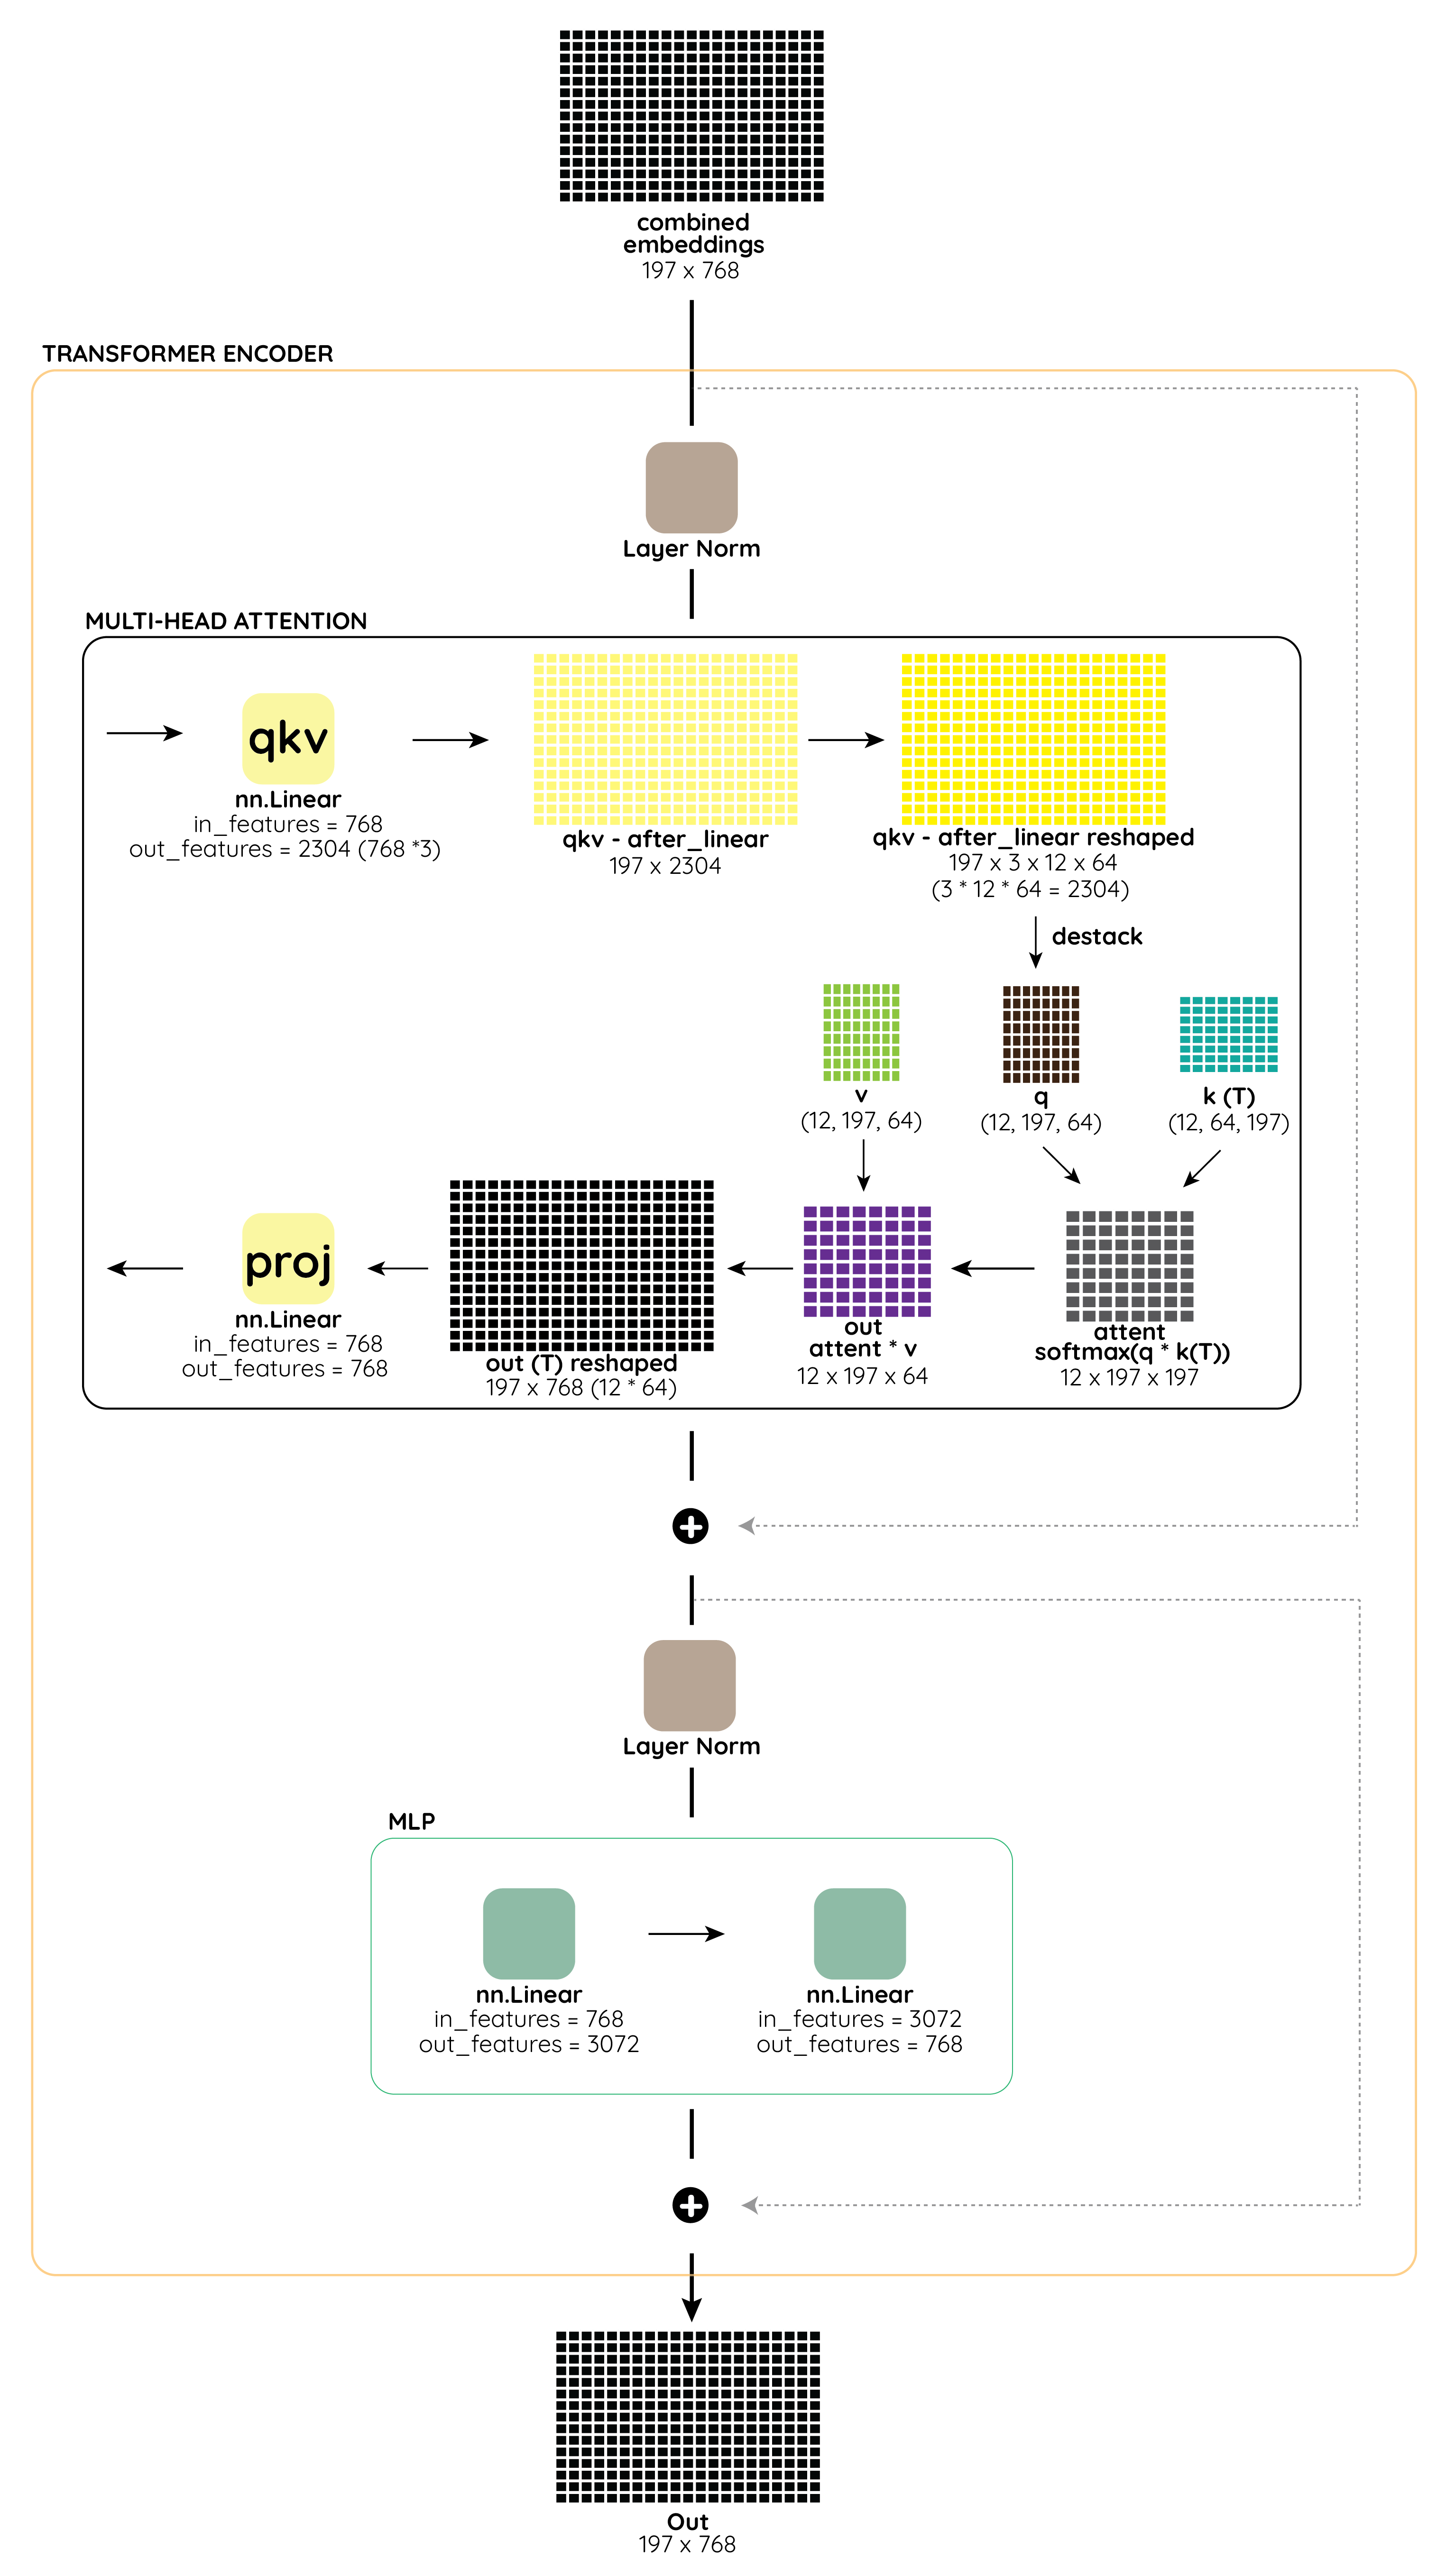

In [49]:
disp_img('/content/vit-07.png')

# Now let us understand how combined embedding is created...i.e. how below circled portion is getting created

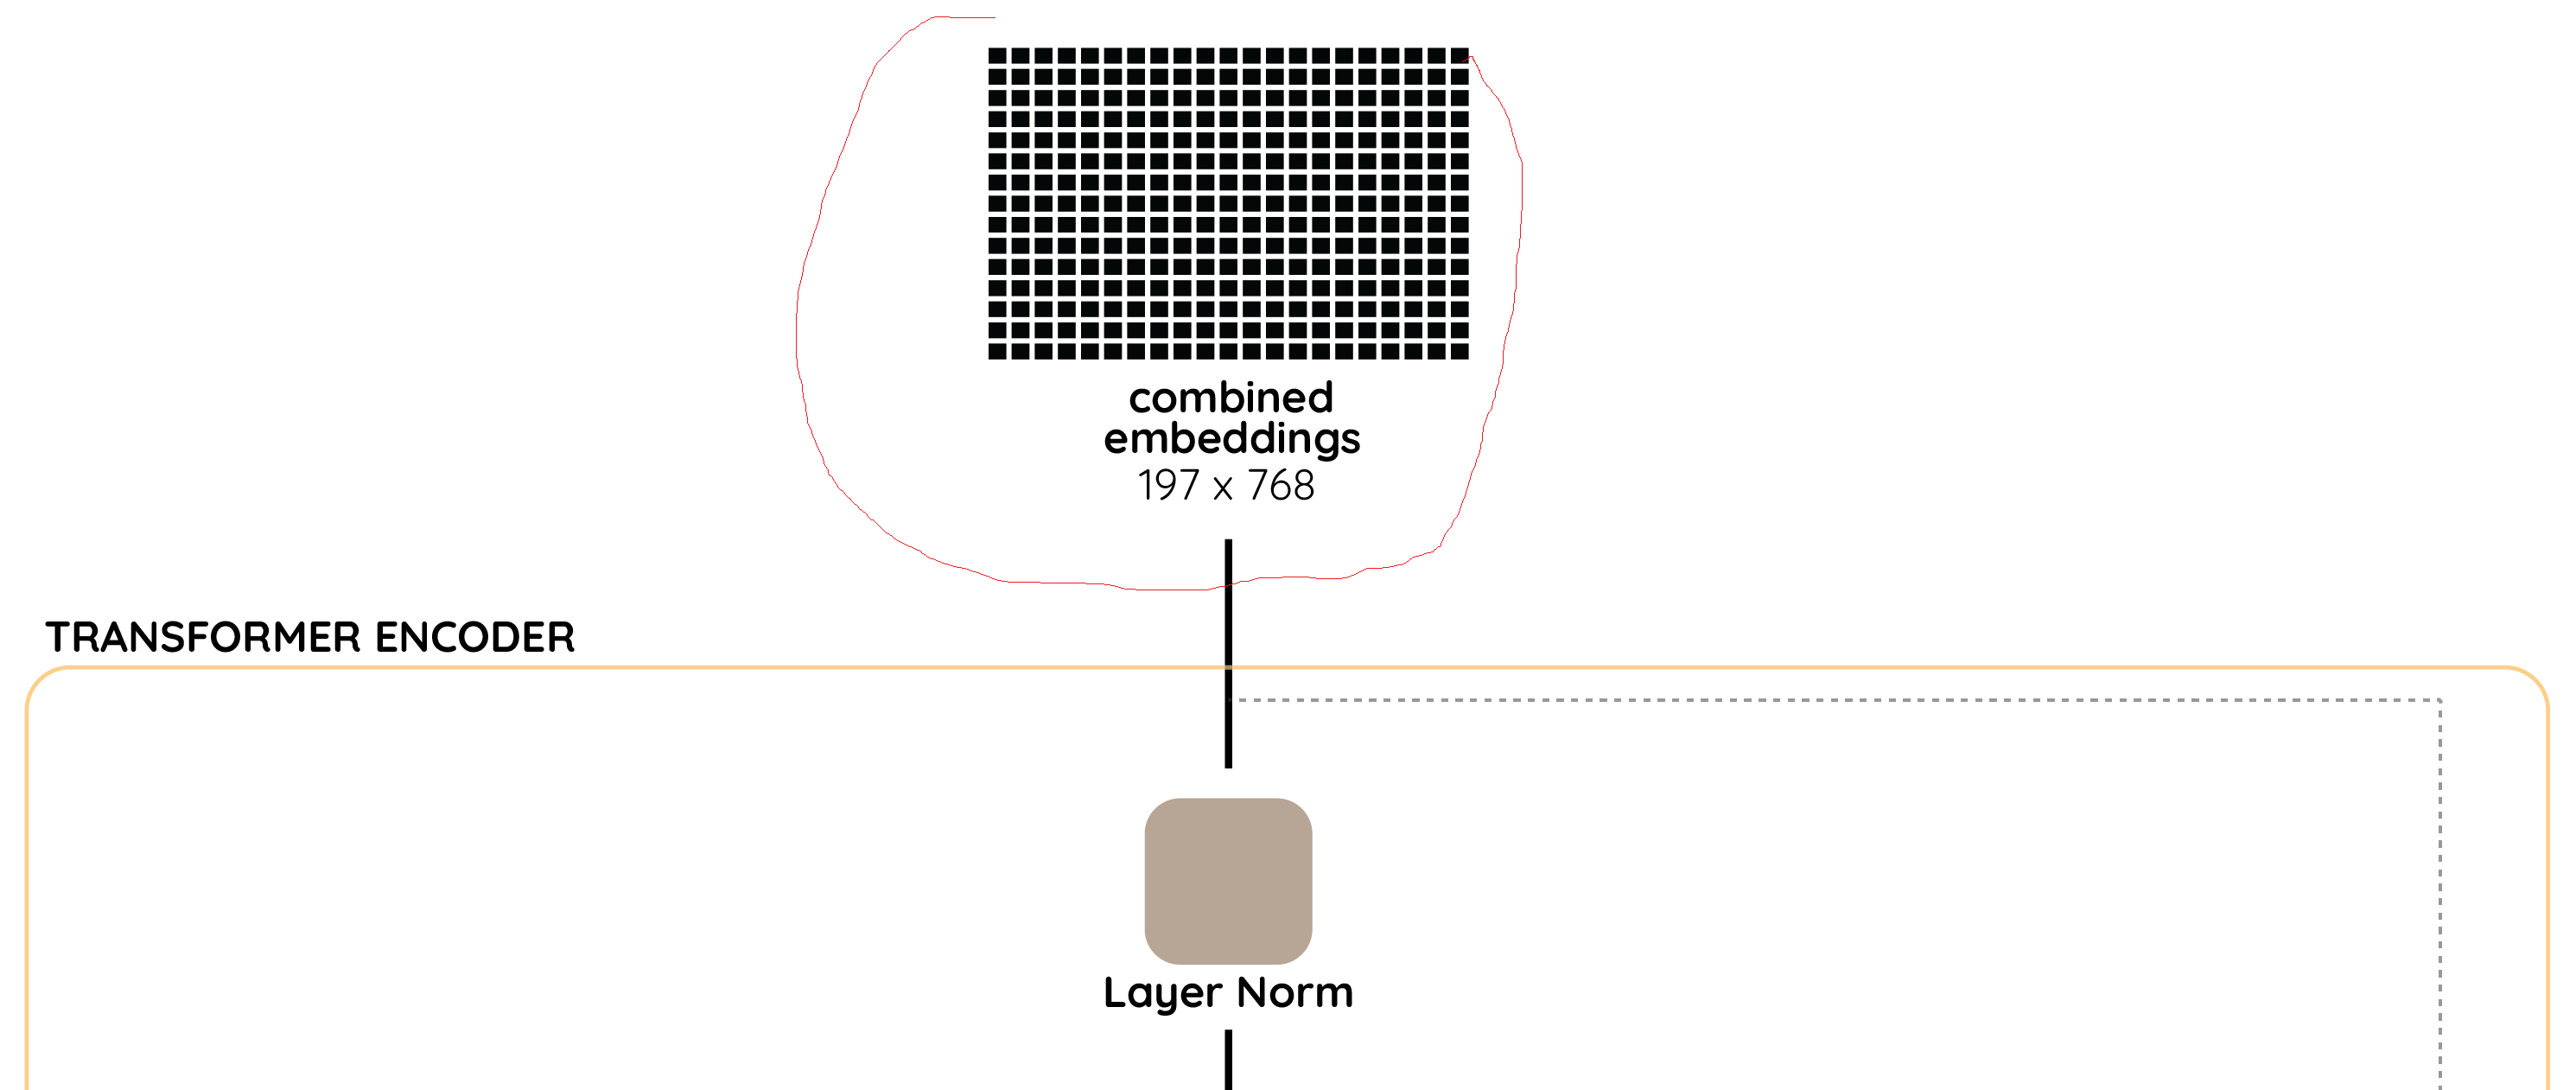

In [5]:
disp_img('/content/Combined_Embedding.png')

In [4]:
def to_2tuple(x):
    if isinstance(x, collections.abc.Iterable):
       return x
    return x, x

img_size = 224
patch_size = 16

img_size = to_2tuple(img_size)
patch_size = to_2tuple(patch_size)

img_size, patch_size

((224, 224), (16, 16))

In [5]:
x = torch.rand((32, 3, 224, 224))
x.shape

torch.Size([32, 3, 224, 224])

In [6]:
proj = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=16, stride=16)           # n_out = [(n_in+2p-k)/s ] + 1
y = proj(x)                                                                            #       = (224 + 2*0 - 16)/16 + 1
y.shape                                                                                #       = 14

torch.Size([32, 768, 14, 14])

In [7]:
y.flatten(2).shape

torch.Size([32, 768, 196])

In [8]:
y.flatten(2).transpose(1,2).shape

torch.Size([32, 196, 768])

In [9]:
class PatchEmbeddings(nn.Module):
     '''
     Image to patch embedding
     '''
     def __init__(self, image_size=224, patch_size=16, num_channels=3, embed_dim=768):
         super().__init__()
         image_size = to_2tuple(image_size)
         patch_size = to_2tuple(patch_size)
         num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])  # (224/16, 224/16) --> (14, 14)
         self.image_size = image_size
         self.patch_size = patch_size  
         self.num_patches = num_patches

         self.projection = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

     def forward(self, pixel_values):
         batch_size, num_channels, height, width = pixel_values.shape

         if height != self.image_size[0] or width != self.image_size[1]:\
             raise ValueError(
                f"Input image size ({height}*{width}) doesn't match model ({self.image_size[0]}*{self.image_size[1]})."
             )         
         x = self.projection(pixel_values).flatten(2).transpose(1, 2)   # Input to nn.Conv2d should be of format (batch_size, num_channels, height, width)
         return x

In [10]:
cls_token = nn.Parameter(torch.zeros(1,1,768))
cls_token.shape

torch.Size([1, 1, 768])

In [11]:
cls_token.expand(32, -1, -1).shape

torch.Size([32, 1, 768])

In [12]:
position_embedding = nn.Parameter(torch.zeros(1, 14*14 + 1, 768))
position_embedding.shape

torch.Size([1, 197, 768])

# Combined embedding creation is well represented via below image

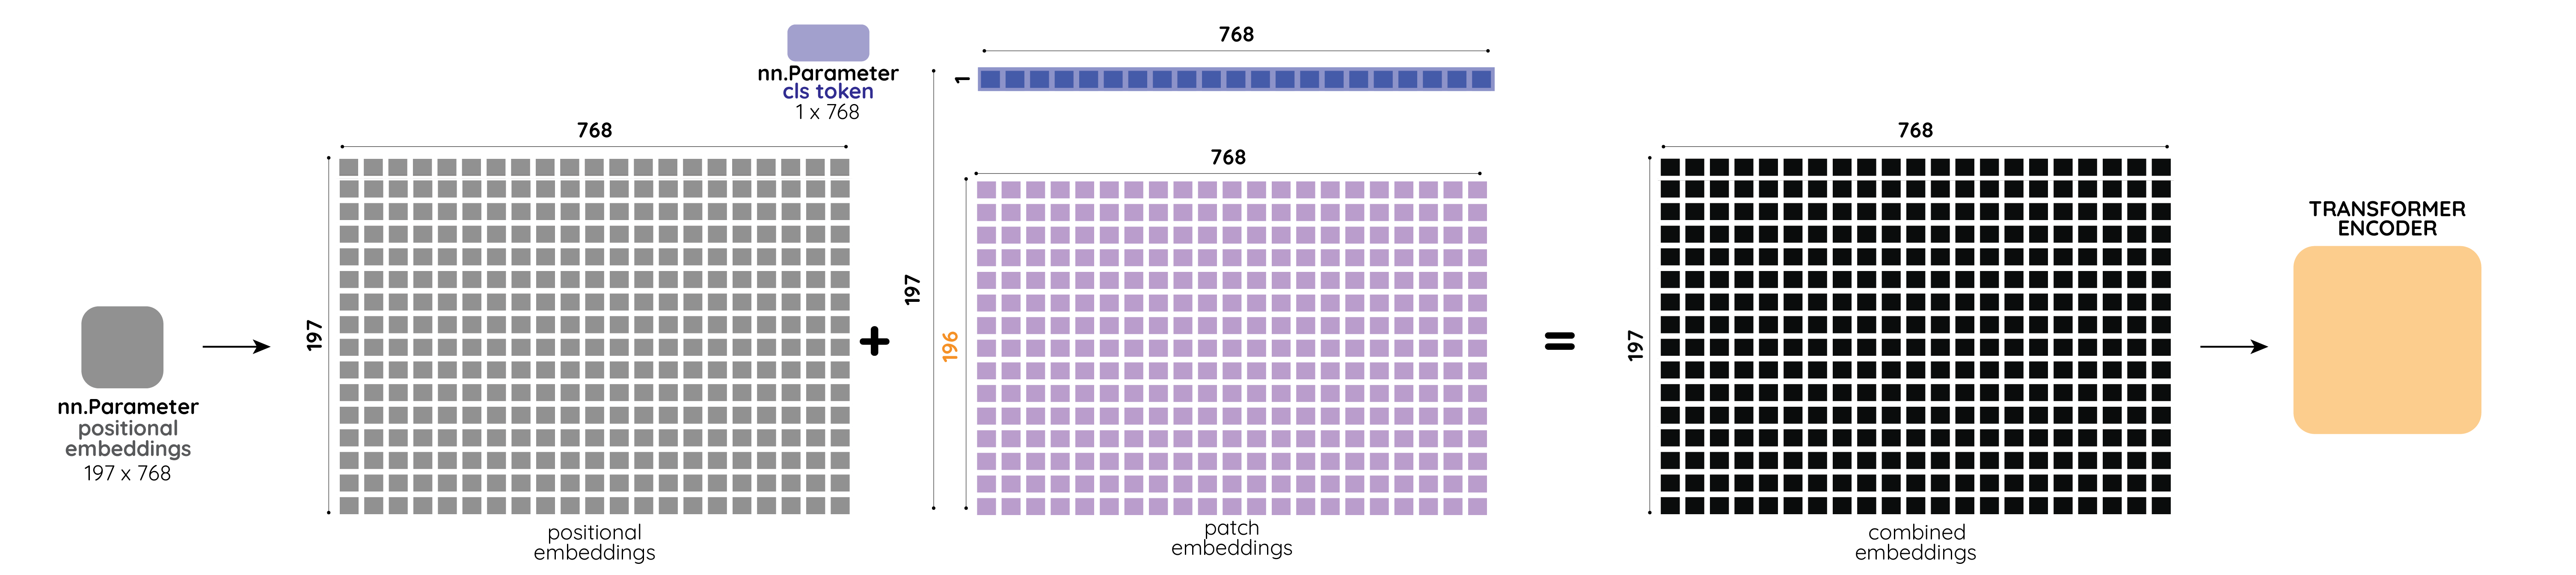

In [15]:
disp_img('/content/vit-03.png')

In [13]:
class ViTEmbeddings(nn.Module):
     '''
     Construct the CLS token, position and patch embeddings.
     '''
     def __init__(self, config):
         super().__init__()

         self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))  # [1, 1, 768]
         self.patch_embeddings = PatchEmbeddings(
              image_size=config.image_size,
              patch_size=config.patch_size,
              num_channels=config.num_channels,
              embed_dim=config.hidden_size,
              )
         num_patches = self.patch_embeddings.num_patches                
         self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches + 1, config.hidden_size)) # No need to expand pos embeddings to batch_size bcoz we will add it with patch_embeddings
         self.dropout = nn.Dropout(config.hidden_dropout_prob)

     def forward(self, pixel_values):
         batch_size = pixel_values.shape[0]
         embeddings = self.patch_embeddings(pixel_values)

         cls_tokens = self.cls_token.expand(batch_size, -1, -1)      # Expand to [32, 1, 768]
         embeddings = torch.cat((cls_tokens, embeddings), dim=1)
         embeddings = embeddings + self.position_embeddings
         embeddings = self.dropout(embeddings)
         return embeddings

In [14]:
class ViTConfig():
     def __init__(
         self,
         hidden_size=768,                     # (32, 3, 224, 224) -> Conv2d(3, 768, 16, 16) -> (32, 768, 14, 14) -> Flatten (32, 768, 196)
         num_hidden_layers=12,                # These are the layers in encoder
         num_attention_heads=12,              # This is for multi-head attention
         intermediate_size=3072,              # 768 * 4 (scaling_factor)
         hidden_act="gelu",
         hidden_dropout_prob=0.0,
         attention_probs_dropout_prob=0.0,
         initializer_range=0.02,
         layer_norm_eps=1e-12,
         is_encoder_decoder=False,
         image_size=224,
         patch_size=16,
         num_channels=3,
         **kwargs
     ):

         self.hidden_size = hidden_size     
         self.num_hidden_layers = num_hidden_layers
         self.num_attention_heads = num_attention_heads
         self.intermediate_size = intermediate_size
         self.hidden_act = hidden_act
         self.hidden_dropout_prob = hidden_dropout_prob
         self.attention_probs_dropout_prob = attention_probs_dropout_prob
         self.initializer_range = initializer_range
         self.layer_norm_eps = layer_norm_eps

         self.image_size = image_size
         self.patch_size = patch_size
         self.num_channels = num_channels

configuration = ViTConfig()
# You can read full configuration file here: https://github.com/huggingface/transformers/blob/master/src/transformers/models/vit/configuration_vit.py

In [15]:
vars(configuration)

{'attention_probs_dropout_prob': 0.0,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.0,
 'hidden_size': 768,
 'image_size': 224,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'layer_norm_eps': 1e-12,
 'num_attention_heads': 12,
 'num_channels': 3,
 'num_hidden_layers': 12,
 'patch_size': 16}

In [16]:
x = torch.rand(32, 3, 224, 224)
vit_emb = ViTEmbeddings(configuration)
vit_emb

ViTEmbeddings(
  (patch_embeddings): PatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

In [17]:
out = vit_emb(x)
out.shape

torch.Size([32, 197, 768])

In [18]:
mat = nn.Linear(768, 12*64) # This is to understand the split to 12 heads
mat = mat(out)
mat.size()

torch.Size([32, 197, 768])

In [19]:
mat.size()[:-1]

torch.Size([32, 197])

In [20]:
new_shape = mat.size()[:-1] + (12, 64)      # Creating new shape corresponding to 12 attention heads
new_shape

torch.Size([32, 197, 12, 64])

In [21]:
print(out.shape)
out = out.view(*new_shape)    # Reshaping the embedding to be fed to 12 attention heads
print(out.shape)

torch.Size([32, 197, 768])
torch.Size([32, 197, 12, 64])


In [22]:
out = out.permute(0, 2, 1, 3)  # Reshaping again to make (batch, head, ..) come first
out.shape

torch.Size([32, 12, 197, 64])

In [23]:
out2 = out

In [24]:
torch.matmul(out2, out)    
# This is to multiply the pixels among themselves to get attention values, but we need to transpose it first else will error as below
# This is equivalent Q * K(T)

RuntimeError: ignored

In [25]:
out2.transpose(-1, -2).shape

torch.Size([32, 12, 64, 197])

In [26]:
attention_scores = torch.matmul(out, out2.transpose(-1, -2))      # This is equivalent Q * K(T)
attention_scores.shape

torch.Size([32, 12, 197, 197])

In [27]:
context_layer = torch.matmul(nn.Softmax(dim=-1)(attention_scores), out)  # Now attention scores need to be multipled with V.
context_layer.shape                                                      # To keep the sum of values = 1, performing softmax on the product

torch.Size([32, 12, 197, 64])

In [28]:
context_layer = context_layer.permute(0, 2, 1, 3)
context_layer.shape

torch.Size([32, 197, 12, 64])

In [29]:
context_layer.size()[:-2] # Now selecting the first 2 dimensions

torch.Size([32, 197])

In [30]:
new_context_layer_shape = context_layer.size()[:-2] + (12*64, )
new_context_layer_shape

torch.Size([32, 197, 768])

In [31]:
print(context_layer.shape)                           # We are shaping back the context_layer to [32, 197, 768]. But needs to be contiguous
context_layer.view(*new_context_layer_shape)
print(context_layer.shape)

torch.Size([32, 197, 12, 64])


RuntimeError: ignored

In [32]:
context_layer = torch.matmul(nn.Softmax(dim=-1)(attention_scores), out)
print('After softmax:', context_layer.shape)
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()    # Making it contiguos while we start permute it from [32, 12, 197, 64] -> [32, 197, 12, 64]
print('After permute:',context_layer.shape)
new_context_layer_shape = context_layer.size()[:-2] + (12*64,)    # Now creating a shape with size [32, 197, 768]
print('New shape:', new_context_layer_shape)
print('Before reshape:',context_layer.shape)
context_layer.view(*new_context_layer_shape)
print('After reshape:',context_layer.shape)

After softmax: torch.Size([32, 12, 197, 64])
After permute: torch.Size([32, 197, 12, 64])
New shape: torch.Size([32, 197, 768])
Before reshape: torch.Size([32, 197, 12, 64])
After reshape: torch.Size([32, 197, 12, 64])


In [33]:
x = torch.randn(3, 2)
y = torch.transpose(x, 0, 1)
print(x)
print(y)

tensor([[ 0.0296, -0.0151],
        [-0.8630, -2.6451],
        [ 1.9892, -0.9365]])
tensor([[ 0.0296, -0.8630,  1.9892],
        [-0.0151, -2.6451, -0.9365]])


In [34]:
x[0, 1] = 42
print(x)
print(y)
print(x.is_contiguous())
print(y.is_contiguous())

tensor([[ 2.9573e-02,  4.2000e+01],
        [-8.6305e-01, -2.6451e+00],
        [ 1.9892e+00, -9.3653e-01]])
tensor([[ 2.9573e-02, -8.6305e-01,  1.9892e+00],
        [ 4.2000e+01, -2.6451e+00, -9.3653e-01]])
True
False


This is where the concept of contiguous comes in. In the example above, x is contiguous but y is not because its memory layout is different to that of a tensor of same shape made from scratch. Note that the word "contiguous" is a bit misleading because it's not that the content of the tensor is spread out around disconnected blocks of memory. Here bytes are still allocated in one block of memory but the order of the elements is different!

When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data

# Now let us build classes that can perform these operations in a meaningful context

# **ViTSelfAttention()** deals with below logic - ie self attention

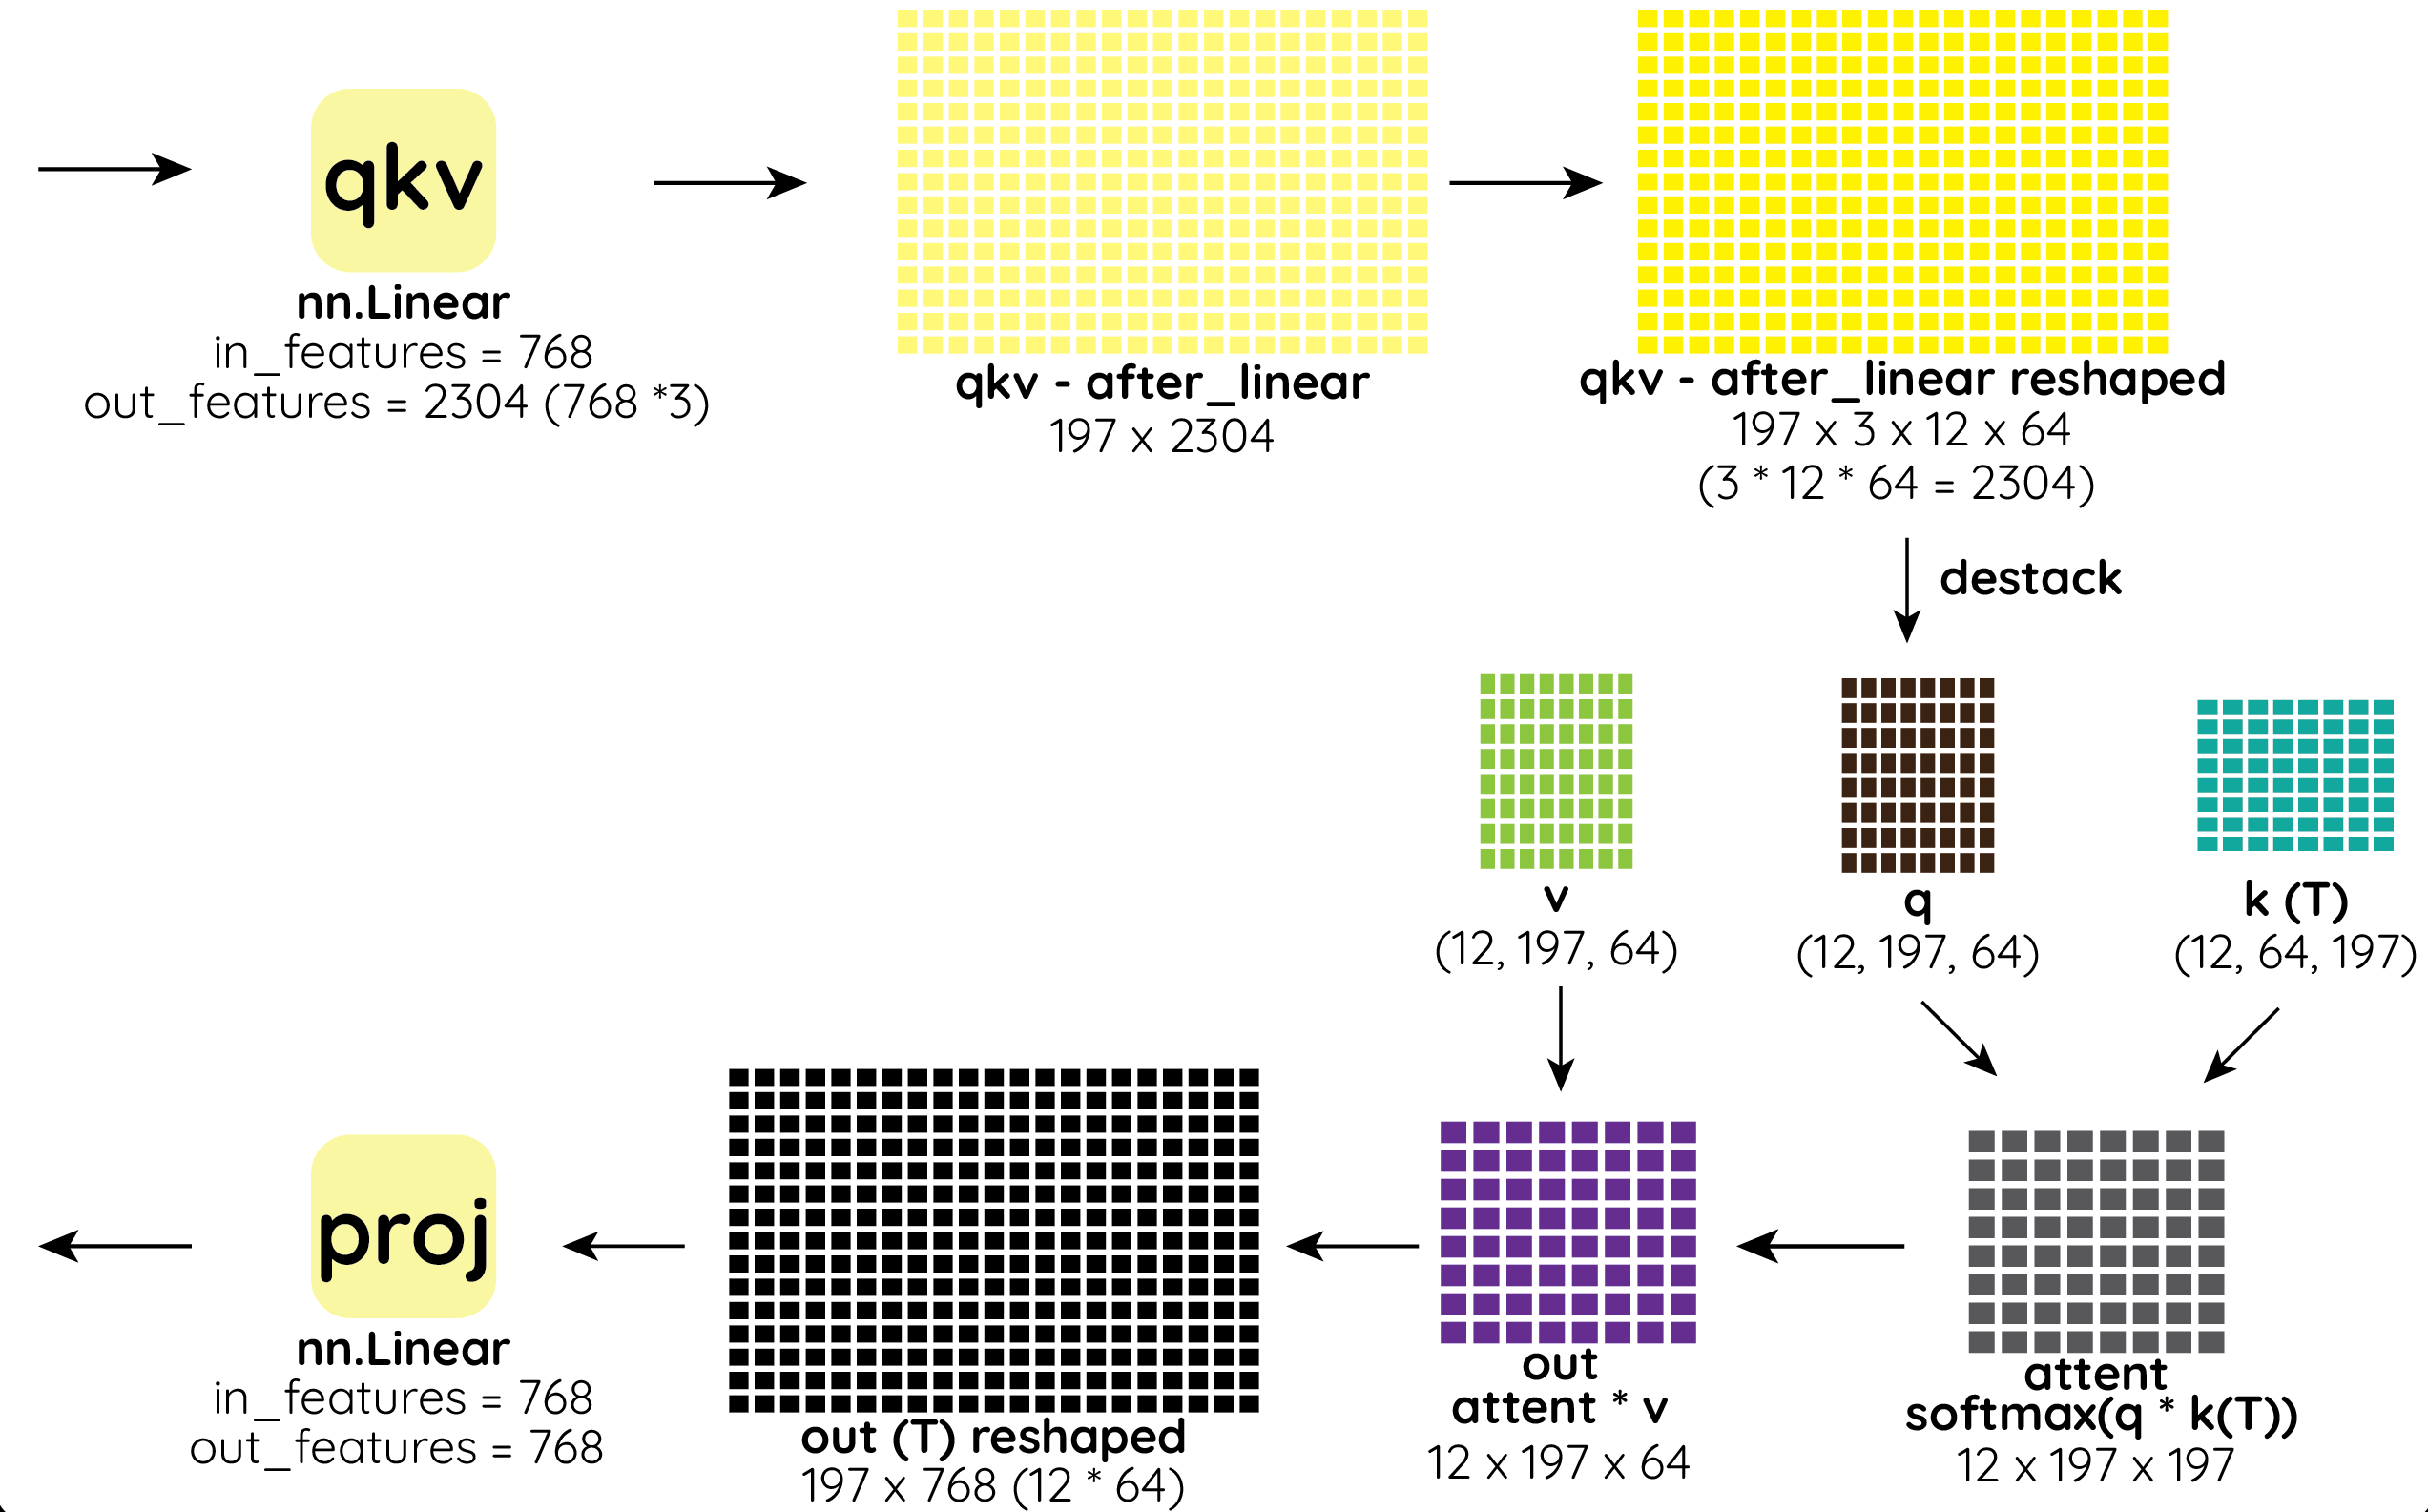

In [41]:
disp_img('/content/Self_Attention.png')

In [59]:
import math
class ViTSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size {config.hidden_size,} is not a multiple of the number of attention "
                f"heads {config.num_attention_heads}."
            )

        self.num_attention_heads = config.num_attention_heads                               # 12
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)     # 768/12 = 64
        self.all_head_size = self.num_attention_heads * self.attention_head_size            # 12*64 = 768

        self.query = nn.Linear(config.hidden_size, self.all_head_size)                      # (768, 768) -> Query prep via FC layer
        self.key = nn.Linear(config.hidden_size, self.all_head_size)                        # (768, 768) -> Key prep via FC layer
        self.value = nn.Linear(config.hidden_size, self.all_head_size)                      # (768, 768) -> Value prep via FC layer

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)                      

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)  # (32, 197) + (12, 64) -> (32, 197, 12, 64)
        x = x.view(*new_x_shape)                                                            # (32, 197, 768) -> (32, 197, 12, 64)
        return x.permute(0, 2, 1, 3)                                                        # (32, 12, 197, 64)

    def forward(self, hidden_states, head_mask=None, output_attentions=True):
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))  # Transposing key to enable matrix multiplication (32,12,197,64)*(32,12,64,197)->(32,12,197,197)

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)  # Dividing to make the softmax operation more meaningful

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)                     # Softmax to keep the sum of values = 1

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)                            # (32, 12, 197, 197)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)                # Multiplying attention vector with original embedding transformed via FC(value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()            # (32, 12, 197, 64) -> (32, 197, 12, 64) 
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)      # (32, 197) + (768,) -> (32, 197, 768)
        context_layer = context_layer.view(*new_context_layer_shape)              # Reshaping back to (32, 197, 768)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
                   #(32,197,768)  #(32,12,197,197) , outputs is a tuple
        return outputs

In [60]:
vit_atn = ViTSelfAttention(configuration)
vit_atn

ViTSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

Let us test the newly created classes now

In [61]:
x = torch.rand((32, 3, 224, 224))
vit_emb = ViTEmbeddings(configuration)
vit_emb

ViTEmbeddings(
  (patch_embeddings): PatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

In [62]:
emb = vit_emb(x)
emb.shape

torch.Size([32, 197, 768])

In [63]:
context_layer, attention_probs = vit_atn(emb, head_mask=None, output_attentions=True)

In [64]:
context_layer.shape, attention_probs.shape

(torch.Size([32, 197, 768]), torch.Size([32, 12, 197, 197]))

In [65]:
class ViTSelfOutput(nn.Module):
     """
     This is just a Linear Layer Block
     """
     def __init__(self, config):
         super().__init__()
         self.dense = nn.Linear(config.hidden_size, config.hidden_size)
         self.dropout = nn.Dropout(config.hidden_dropout_prob)

     def forward(self, hidden_states, input_tensor):
         hidden_states = self.dense(hidden_states)
         hidden_states = self.dropout(hidden_states)

         return hidden_states

In [67]:
class ViTAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = ViTSelfAttention(config)
        self.output = ViTSelfOutput(config)
        self.pruned_heads = set()

    # WE ARE NOT USING PRUNE_HEADS IN THIS NOTEBOOK
    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.attention.num_attention_heads, self.attention.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.attention.query = prune_linear_layer(self.attention.query, index)
        self.attention.key = prune_linear_layer(self.attention.key, index)
        self.attention.value = prune_linear_layer(self.attention.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.attention.num_attention_heads = self.attention.num_attention_heads - len(heads)
        self.attention.all_head_size = self.attention.attention_head_size * self.attention.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(self, hidden_states, head_mask=None, output_attentions=True):
        self_outputs = self.attention(hidden_states, head_mask, output_attentions)
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # Include attentions also in outputs if we want to output them 
                                                          # outputs is a tuple -> ( [32, 197, 768] , [32, 12, 197, 197] )
        return outputs

# MLP Blocks - ViTIntermediate & ViTOutput

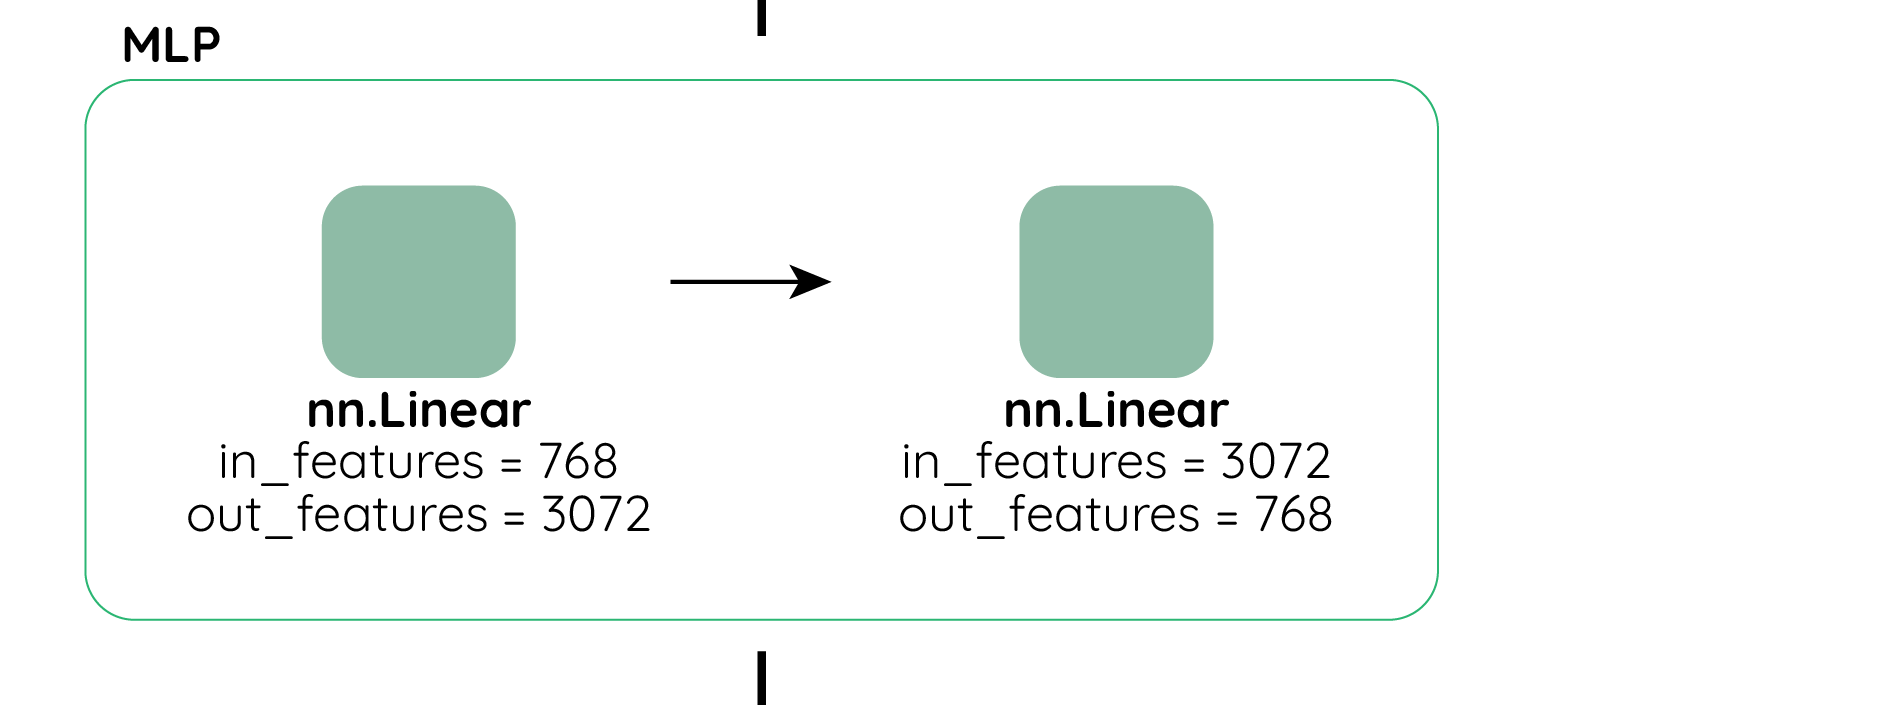

In [90]:
disp_img('/content/MLP.png')

In [43]:
# Scaling up by 4 from 768 to 3072

class ViTIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)

    def forward(self, hidden_states):

        hidden_states = self.dense(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states)

        return hidden_states

In [44]:
# Scaling back from from 3072 to 768

class ViTOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        hidden_states = hidden_states + input_tensor

        return hidden_states

# **ViTLayer()** that brings below flow to action

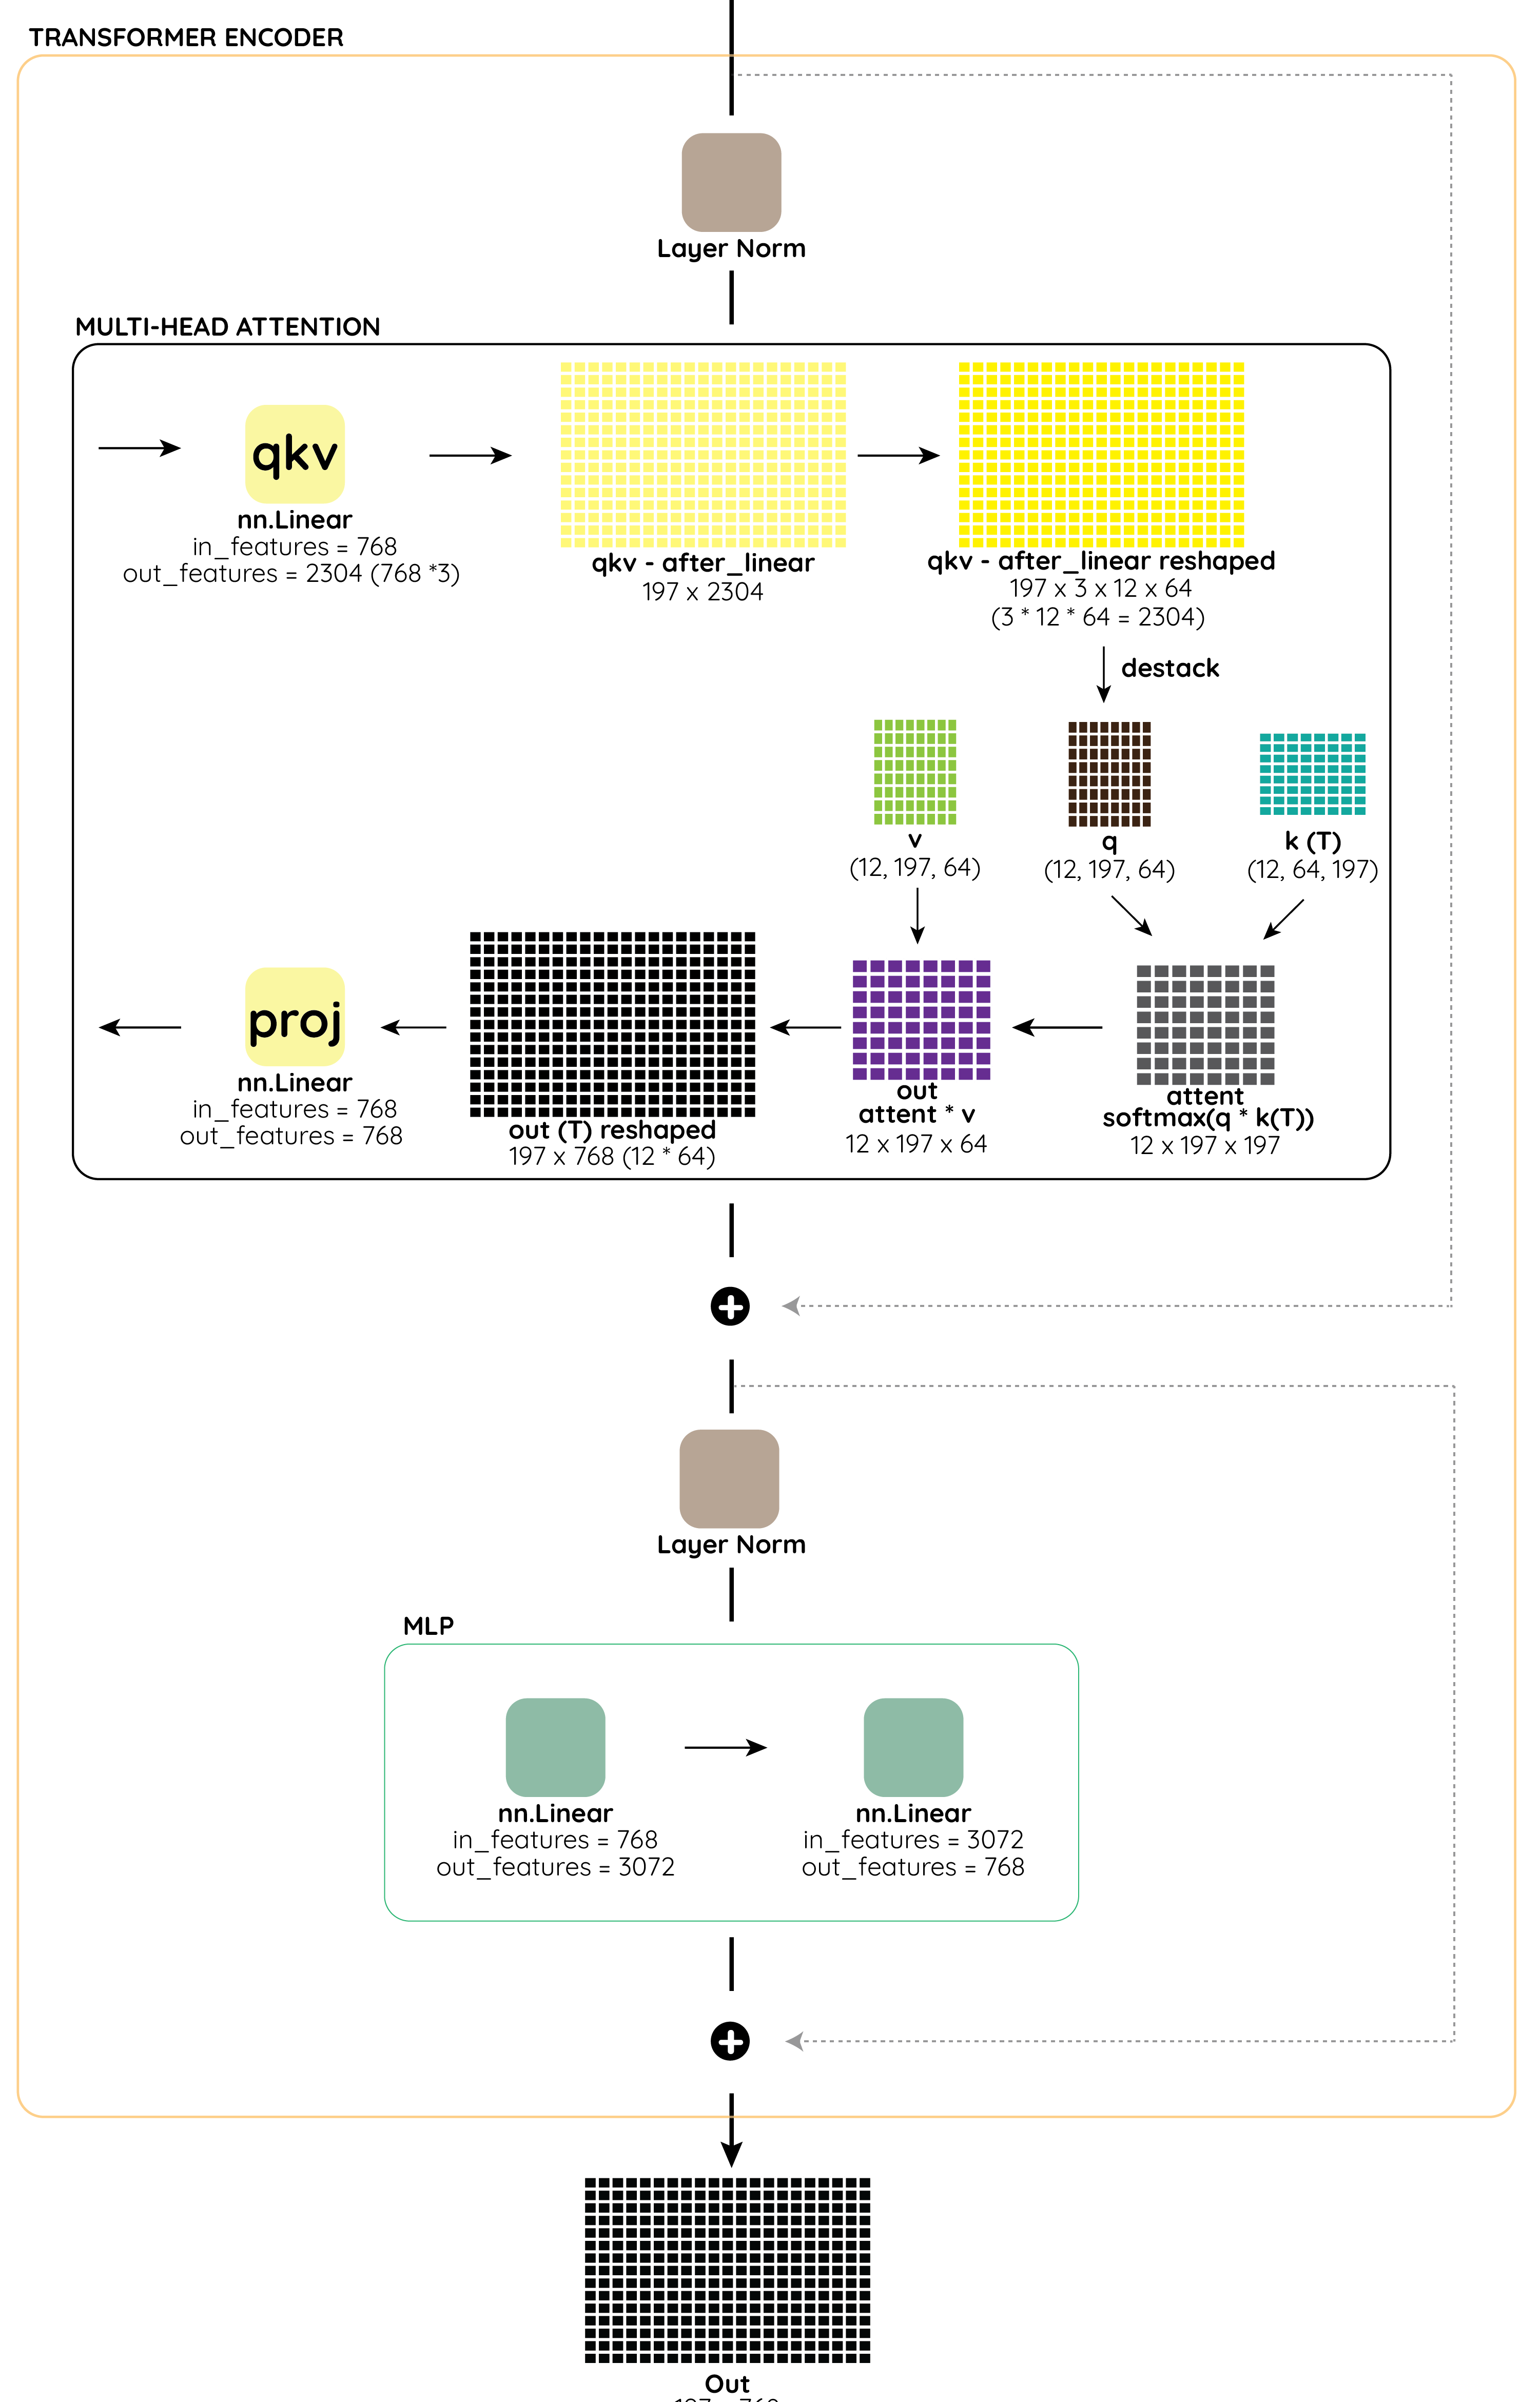

In [93]:
disp_img('/content/ViTLayer.png')

In [68]:
class ViTLayer(nn.Module):
    """This corresponds to the Block class in the timm implementation."""

    def __init__(self, config):
        super().__init__()
        self.seq_len_dim = 1
        self.attention = ViTAttention(config)
        self.intermediate = ViTIntermediate(config)
        self.output = ViTOutput(config)
        self.layernorm_before = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.layernorm_after = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states, head_mask=None, output_attentions=True):
        self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states),  # in ViT, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights
        # first residual connection
        hidden_states = attention_output + hidden_states

        # in ViT, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)

        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)   #[32, 197, 768]

        outputs = (layer_output,) + outputs                       # Please note that we are doing tuple addition here & NOT tensor addition                              
        return outputs

    # No NEED to bother at this point on below
    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output)
        return layer_output

In [69]:
# Encoder runs 12 times as we gave num_hidden_layers = 12 in configuration. Will execute the attention layer 10 times

class ViTEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([ViTLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(
        self,
        hidden_states,
        head_mask=None,
        output_attentions=True,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if getattr(self.config, "gradient_checkpointing", False) and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    layer_head_mask,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)
        
        return hidden_states,all_hidden_states,all_self_attentions


# **ViTPooler** that passes only [CLS] token to Final FC layer for classification. 

In [70]:
class ViTPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

### VIT-MODEL where everything comes together !

In [71]:
class ViTModel():
    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = ViTEmbeddings(config)
        self.encoder = ViTEncoder(config)

        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.pooler = ViTPooler(config) if add_pooling_layer else None

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.patch_embeddings


    def forward(
        self,
        pixel_values=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Returns:

        Examples::

            >>> from transformers import ViTFeatureExtractor, ViTModel
            >>> from PIL import Image
            >>> import requests

            >>> url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
            >>> image = Image.open(requests.get(url, stream=True).raw)

            >>> feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
            >>> model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

            >>> inputs = feature_extractor(images=image, return_tensors="pt")
            >>> outputs = model(**inputs)
            >>> last_hidden_states = outputs.last_hidden_state
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(pixel_values)

        encoder_outputs = self.encoder(
            embedding_output,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return sequence_output,pooled_output,encoder_outputs.hidden_states,encoder_outputs.attentions


In [72]:
out.shape, configuration

(torch.Size([32, 12, 197, 64]), <__main__.ViTConfig at 0x7fe29c950bd0>)

In [73]:
vit_enc = ViTEncoder(configuration)

In [74]:
vit_enc

ViTEncoder(
  (layer): ModuleList(
    (0): ViTLayer(
      (attention): ViTAttention(
        (attention): ViTSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (output): ViTSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (intermediate): ViTIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
      )
      (output): ViTOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine

In [75]:
input = torch.rand((32, 3, 224, 224))
embeddings = ViTEmbeddings(configuration)
encoder = ViTEncoder(configuration)
layernorm = nn.LayerNorm(configuration.hidden_size, eps=0.000001)

In [76]:
embedding_output = embeddings(input)
embedding_output.shape

torch.Size([32, 197, 768])

In [77]:
encoder_output = encoder(embedding_output)

In [78]:
type(encoder_output), len(encoder_output)

(tuple, 3)

In [83]:
type(encoder_output[0]), type(encoder_output[1]), type(encoder_output[2]), len(encoder_output[2]), type(encoder_output[2][0])

(torch.Tensor, NoneType, tuple, 12, torch.Tensor)

In [86]:
hidden_states, all_hidden_states, all_self_attentions = encoder_output

hidden_states.shape, all_hidden_states, all_self_attentions[0].shape
# "all_self_attentions" will be a tuple having 12 elements - each element corresponding to the attention matrix for that particular 
# encoder layer. Since there are 12 encoder layers, there will be 12 attention matrices also each of size [32, 12, 197, 197]

(torch.Size([32, 197, 768]), None, torch.Size([32, 12, 197, 197]))

In [87]:
sequence_output = encoder_output[0]
sequence_output.shape

torch.Size([32, 197, 768])

In [88]:
sequence_output[:, 0].shape

torch.Size([32, 768])

In [89]:
sequence_output = encoder_output[0]
layernorm = nn.LayerNorm(configuration.hidden_size, eps=0.00001)
sequence_output = layernorm(sequence_output)
# VitPooler
dense = nn.Linear(configuration.hidden_size, configuration.hidden_size)
activation = nn.Tanh()
first_token_tensor = sequence_output[:, 0]
pooled_output = dense(first_token_tensor)   # Passing only [CLS] token
pooled_output = activation(pooled_output)
pooled_output.shape

torch.Size([32, 768])

In [90]:
# If we have 100 classes to classify

classifier = nn.Linear(configuration.hidden_size, 100)  # [32, 768] -> [32, 100]
logits = classifier(pooled_output)
logits.shape

torch.Size([32, 100])